In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.covariance import MinCovDet
from sklearn.datasets import make_gaussian_quantiles

In [2]:
def plot_ellipse(mean, covariance, X2_critical = 5.991, pca_method = True):
    
    if covariance.shape[0] == 2:
        
        t = np.linspace(0, 2 * np.pi, 1000)

        eig_vals, eig_vect = np.linalg.eig(covariance)

        pos_max = np.argmax(eig_vals)
        pos_min = np.abs(1 - pos_max)
    
        
        a = np.sqrt(X2_critical * eig_vals[pos_max])
        b = np.sqrt(X2_critical * eig_vals[pos_min])
        
        z = np.array([a * np.cos(t), b * np.sin(t)]).T

        
        if not pca_method:
            #Method 1
            alpha = np.arctan(eig_vect[1, pos_max] / eig_vect[0, pos_max])# - np.pi/2
            
            R = np.array([[np.cos(alpha), -np.sin(alpha)],
                          [np.sin(alpha), np.cos(alpha)]])

            #x = R . z
            #x.T = z . R.T
            X = np.dot(z, R.T)
        else:
            #Method 2
            #Basically performing reverse of PCA, generate data in Z space, project back using eigenvectors
            ordered_eig_vect = eig_vect[:, [pos_max, pos_min]] #Rotate using Eigenvectors!
            
            #x = U * z
            #x.T = z . U.T
            X = np.dot(z, ordered_eig_vect.T)
        
        return mean + X

In [3]:
import numpy as np
from scipy import linalg
from scipy.stats import chi2

class MinCovDet_manual(object):

    def __init__(self, store_precision=True, support_fraction=None, random_state=None, verbose = False):
        
        self.store_precision = store_precision
        self.support_fraction = support_fraction
        self.verbose = verbose
        if random_state is None:
            self.random_state = np.random.mtrand._rand
        
        else:
            self.random_state = np.random.RandomState(random_state)
    
    def c_step(self, X, n_support, initial_estimate = None, n_iterations = 30):
        
        n_samples, n_features = X.shape
        dist = np.inf
        
        support = np.zeros(n_samples, dtype = bool)
        
        if initial_estimate is not None:
            location = initial_estimate[0]
            covariance = initial_estimate[1]
            
            precision = linalg.pinvh(covariance)
            
            X_centered = X - location
            
            dist = np.sum(np.dot(X_centered, precision) * X_centered, axis = 1)
            
            support[np.argsort(dist)[:n_support]] = True
        
        else:
            support[self.random_state.permutation(n_samples)[:n_support]] = True
        
        X_support = X[support]
        
        location = np.mean(X_support, axis = 0)
        covariance = np.cov(X_support, rowvar = False)
        
        det = max(linalg.det(covariance), 0) #Cap at zero, don't need negative determinants
        
        cnt = 0
        prev_det = np.inf
        
        while det < prev_det and cnt < n_iterations and det != 0:
            
            prev_location = location
            prev_covariance = covariance
            prev_det = det
            prev_support = support
            prev_dist = dist
            
            #1. Compute old distances
            prev_precision = linalg.pinvh(prev_covariance)
            X_centered = X - prev_location
            dist = np.sum(np.dot(X_centered, prev_precision) * X_centered, axis = 1)
            
            #2. Sort distances
            support = np.zeros(n_samples, dtype = bool)
            support[np.argsort(dist)[:n_support]] = True
            
            #3. Compute new X_support
            X_support = X[support]
            
            #4. Compute new location and covariance
            
            location = np.mean(X_support, axis = 0)
            covariance = np.cov(X_support, rowvar = False)
            precision = linalg.pinvh(covariance)
            
            det = max(linalg.det(covariance), 0) 
            
            #Update iteration counter
            cnt += 1
        
        dist = np.sum(np.dot(X - location, precision) * (X - location), axis = 1)
        
        if np.allclose(det, prev_det):
            
            if self.verbose:
                print("Optimal MCD location and covariance found before iteration cap ({} left)".format(n_iterations - cnt))
            
            results = (location, covariance, det, support, dist)
            
        elif det > prev_det:
            if self.verbose:
                print("The determinant has increased, try to increase the number of supports. Current fraction: {:.3f}%".format(n_support / n_samples))
            
            results = (prev_location, prev_covariance, prev_det, prev_support, prev_dist)
        
        if cnt == n_iterations:
            if self.verbose:
                print("Maximum number of iterations reached.")
            
            results = (location, covariance, det, support, dist)
        
        return results
    
    def correction_step(self, X):
        
        n_samples, n_features = X.shape
        
        c1 = np.median(self.dist_) / chi2(n_features).isf(0.5)
        
        self.dist_ /= c1 #Normalise the distance**2 measure, as this will allow you to use 
        #both the weighting step and the correction step
        #Remember, weighted are allocated to dist, and dist is applied to every index of the covariance. 
        #(cS)^-1 = 1/c S^-1, where c is a constant 
    
    def weighting_step(self, X):
        
        n_samples, n_features = X.shape
        
        mask_support = np.zeros(n_samples, dtype = bool)
        
        mask = self.dist_ < chi2(n_features).isf(0.025)
        mask_support[mask] = True
        
        X_mask = X[mask_support]
        
        self.location_ = np.mean(X_mask, axis = 0)
        
        self.covariance_ = np.cov(X_mask - self.location_, rowvar = False)
        
        if self.store_precision:
            self.precision_ = linalg.pinvh(self.covariance_)

    def fast_mcd(self, X):
                
        n_samples, n_features = X.shape
        
        # minimum breakdown value
        if self.support_fraction is None:
            n_support = int(np.ceil((n_samples + n_features + 1) / 2))
            
        else:
            n_support = int(self.support_fraction * n_samples)
        
        if n_features == 1: #TODO - read 1d paper
            pass
        
        elif n_samples < 600 and n_features >= 2:
            
            n_iter = 500
            n_final = 10
            
            det_iter = np.zeros(n_iter)
            iter_results = []
            
            for i in range(n_iter):
                
                #Initial p + 1 results
                init_location, init_covariance, _, _, _ = self.c_step(X, 
                                                                      n_features + 1, 
                                                                      initial_estimate = None, 
                                                                      n_iterations = 1)
                
                #Use initial results for next 2 iterations for full support
                result_init = self.c_step(X, n_support, 
                                         initial_estimate = (init_location, init_covariance), 
                                         n_iterations = 2)
                
                
                det_iter[i] = result_init[2]
                iter_results.append(result_init)
            
            index_sort = np.argsort(det_iter)
            
            det_optimal = det_iter[index_sort[0]] #Store smallest determinant
            result_optimal = iter_results[index_sort[0]]
            
            for i in index_sort[:n_final]:
                
                index_location = iter_results[i][0]
                index_covariance = iter_results[i][1]
                
                result_index = self.c_step(X, n_support, 
                                           initial_estimate = (index_location, index_covariance), 
                                           n_iterations = 30)
                
                #Check if results are better
                if result_index[2] < det_optimal:
                    det_optimal = result_index[2]
                    result_optimal = result_index    
        
        elif n_samples > 600 and n_features >= 2:
            
            subset_size = 300
            n_subsets = min(5, n_samples // subset_size)
            n_local_iter = 500
            n_iter_subsets = n_local_iter // n_subsets
            local_support = int(subset_size * n_support / n_samples)
            merged_support = int(n_subsets * subset_size * n_support / n_samples)
            n_local_best = 10
            n_final = 10
            
            print("n_subsets: {}\nn_iter_subsets; {}\nlocal_support: {}\nmerged_support: {}".format(n_subsets, n_iter_subsets, local_support, merged_support))
            
            results_init = np.zeros((n_subsets, n_iter_subsets))
            
            index_subsets = self.random_state.permutation(n_samples)[:n_subsets * subset_size]
            
            det_local_iter = np.zeros(n_subsets * n_iter_subsets)
            results_local_iter = []
            
            #Local iteration
            cnt = 0
            for i in range(n_subsets):
                
                index_local = index_subsets[i * subset_size: (i + 1) * subset_size]
                
                for j in range(n_iter_subsets):
                    
                    #Initial local support results
                    local_results = self.c_step(X[index_local, :], 
                                                local_support, 
                                                initial_estimate = None, 
                                                n_iterations = 2)
                    
                    #Store results
                    det_local_iter[cnt] = local_results[2]
                    results_local_iter.append(local_results)
                    cnt += 1
            
            #Keep 10 best results for each subset
            local_results_optimal = []
            
            for i in range(n_subsets):
                det_subsets = det_local_iter[i * n_iter_subsets : (i + 1) * n_iter_subsets]
                
                local_index = np.argsort(det_subsets)
                
                #Store the 10 best in the local_results_optimal
                for j in local_index[:n_local_best]:
                    #print(i, j + i * n_iter_subsets, det_subsets[j])
                    
                    local_results_optimal.append(results_local_iter[j + i * n_iter_subsets])
                    
            #Merged iteration - repeated for all the optimal local results
            det_merged_iter = np.zeros(len(local_results_optimal))
            merged_results_iter = []
            
            for cnt, results_lm in enumerate(local_results_optimal):
                
                #Use local on merged dataset
                merged_results = self.c_step(X[index_subsets, :], 
                                             merged_support, 
                                             initial_estimate = (results_lm[0], results_lm[1]), 
                                             n_iterations = 2)
                
                det_merged_iter[cnt] = merged_results[2]
                merged_results_iter.append(merged_results)
            
            #Keep n_final best iterations and run on full dataset
            index_sort = np.argsort(det_merged_iter)
            det_optimal = np.inf
            results_optimal = None
            
            for i in index_sort[:n_final]:

                result_index = self.c_step(X, 
                                           n_support, 
                                           initial_estimate = (merged_results_iter[i][0], merged_results_iter[i][1]), 
                                           n_iterations = 30)
                
                #Check if results are better
                if result_index[2] < det_optimal:
                    det_optimal = result_index[2]
                    result_optimal = result_index    
            
        
        return result_optimal #location, covariance, det, support, dist
    
    def fit(self, X):
        
        fMCD_location, fMCD_covariance, fMCD_det, fMCD_support, fMCD_dist = self.fast_mcd(X)
        
        #Store components
        self.location_ = fMCD_location
        self.covariance_ = fMCD_covariance
        self.det_ = fMCD_det
        self.support_ = fMCD_support
        self.dist_ = fMCD_dist
        
        #Correct covariance using C1 factor
        self.correction_step(X)
        
        #Correct covariance using weighting
        self.weighting_step(X)
        
        if self.store_precision:
            self.precision_ = linalg.pinvh(self.covariance_)
        
        return self
    
    def score(self, X):
        #Returns the Mahalanobis distance
        #N x F or F x 1 input X
        
        r, c = X.shape
        
        X_centered =  X - self.location_
        
        if c == 1:
        
            if self.store_precision_:
                MCD_dist = np.dot(X_centered, np.dot(self.precision_, X_centered))
            
            else:
                SinvU = np.linalg.solve(self.GM_covariance, X_centered)
                MCD_dist = np.dot(X_centered.T, SinvU)
        
        else:
            if self.store_precision_:
                MCD_dist = np.sum(np.dot(X_centered, self.precision_) * X_centered, axis = 1)
                
            else:
                precision = linalg.pinvh(self.covariance_)
                MCD_dist = np.sum(np.dot(X_centered, precision) * X_centered, axis = 1)
        
        return np.sqrt(MCD_dist)

n_subsets: 5
n_iter_subsets; 100
local_support: 150
merged_support: 750


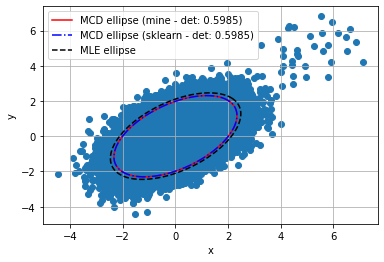

In [5]:
real_cov = np.array([[1, 0.5],
                     [0.5, 1]])

rng = np.random.RandomState(0)

X = rng.multivariate_normal(mean=[0, 0],
                                  cov=real_cov,
                                  size=400)

X_outlier = rng.multivariate_normal(mean=[5, 5],
                                    cov=np.eye(2),
                                    size=30)

X = np.vstack((X, X_outlier))

MCD1 = MinCovDet_manual().fit(X)
MCD2 = MinCovDet().fit(X)

Xellipse1 = plot_ellipse(MCD1.location_, MCD1.covariance_)
Xellipse2 = plot_ellipse(MCD2.location_, MCD2.covariance_)
Xellipse3 = plot_ellipse(np.mean(X, axis = 0), np.cov(X, rowvar = False))

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.plot(Xellipse1[:, 0], Xellipse1[:, 1], "r-", label = "MCD ellipse (mine - det: {:.4f})".format(np.linalg.det(MCD1.covariance_)))
plt.plot(Xellipse2[:, 0], Xellipse2[:, 1], "b-.", label = "MCD ellipse (sklearn - det: {:.4f})".format(np.linalg.det(MCD2.covariance_)))
plt.plot(Xellipse3[:, 0], Xellipse3[:, 1], "k--", label = "MLE ellipse")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()